# Project 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import os
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
# trying different models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


# The following line is needed to show plots inline in notebooks
%matplotlib inline 

In [2]:
data = pd.read_csv('train.csv')
data.shape

(15555, 7)

In [3]:
cur_path = os.path.dirname(os.path.abspath("project.ipynb"))
articles_dir = cur_path + '/train_articles/'

## Data Cleaning

### Claimant

In [4]:
# There are 4962 missing values in claimant
missing_claim = data[data['claimant'].isna()]
missing_claim.shape[0]

4962

In [5]:
# Of the claimant missing, how many are false-0, partly true-1, true-2?
missing_data = data[data['claimant'].isna()]
missing_data.label.value_counts(normalize=True)
# roughly 87% of claims with missing claimants are not completely true

0    0.611447
1    0.259371
2    0.129182
Name: label, dtype: float64

In [6]:
# fill missing claimants with "unknown"
data['claimant'] = data['claimant'].fillna('Unknown')

In [7]:
claimant_count = data['claimant'].value_counts()

In [8]:
# Group together all counts less than 100 in to Others
value_mask = data.claimant.isin(claimant_count.index[claimant_count < 5]) 
data.loc[value_mask,'claimant'] = "Other"
# data.claimant.value_counts()

### Date

In [9]:
# 5% of data happen on 2 separate days, November 6th 2017 and October 23rd 2016
date_count = data['date'].value_counts()

In [10]:
# On average, about 5 claims happen a day
data.date.value_counts().mean()

5.152368333885392

In [11]:
# Convert date column to datetime format
data['new_date'] = pd.to_datetime(data['date'], dayfirst=True)

In [12]:
# # sort by Date (earliest (May 6th, 1986) to latest (April 30th, 2019))
# data.sort_values(by = 'new_date')

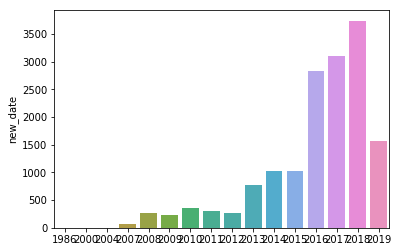

In [13]:
# claims per year
sns.barplot(x=data['new_date'].dt.year.value_counts().index, y=data['new_date'].dt.year.value_counts())

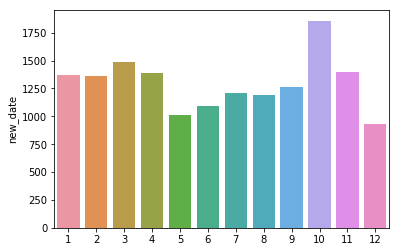

In [14]:
# Claims per month
sns.barplot(x=data['new_date'].dt.month.value_counts().index, y=data['new_date'].dt.month.value_counts())

In [15]:
# fake/real claims per month
month = data[data['new_date'].dt.year == 2018]
month.label.value_counts()

0    2115
1    1244
2     378
Name: label, dtype: int64

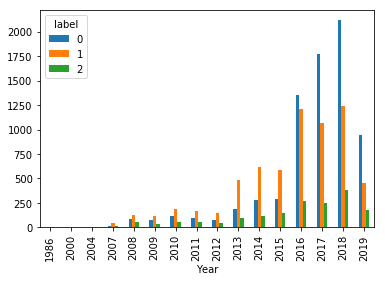

In [16]:
# Plot labels against each year
data['Year'] = data['new_date'].apply(lambda x: "%d" % (x.year))
year_label = data.groupby(['Year', 'label']).size().unstack(fill_value=0)
year_label.plot.bar()
# 0 = false, 1 = partly true, 2 = true

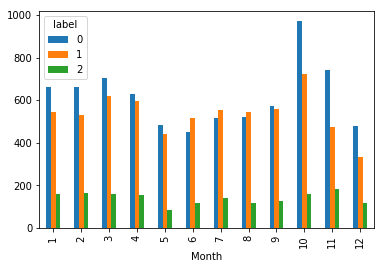

In [17]:
# Plot labels against each month
data['Month'] = data['new_date'].apply(lambda x: "%d" % (x.month))
month_label = data.groupby(['Month', 'label']).size().unstack(fill_value=0)
# For some reason, have to reorder the month index by adding a new column
month_order = [1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]
month_label['month'] = month_order
month_label = month_label.sort_values(by=['month'])
# Dropping the added column as it is not needed after reordering
month_label = month_label.drop(['month'], axis=1)
month_label.plot.bar()

In [18]:
# fake_data = data[data['label'] == 0]
# fake_data_month = fake_data[fake_data['new_date'].dt.month==10]
# fake_data_month.label.value_counts()

In [19]:
# # Created a month dataframe
# month_index = data['new_date'].dt.month.value_counts().index.tolist()
# month_count = data['new_date'].dt.month.value_counts().tolist()
# month_data = pd.DataFrame(columns=['Month', 'Count'])
# month_data['Month'] = month_index
# month_data['Count'] = month_count
# month_data

In [20]:
# # Group together all counts less than average in to Others
# value_mask = data.date.isin(date_count.index[date_count < 5]) 
# data.loc[value_mask,'date'] = "Other"
# # data.date.value_counts()

### Related Articles 

In [21]:
# related articles is of type object
data.dtypes

Unnamed: 0                   int64
claim                       object
claimant                    object
date                        object
id                           int64
label                        int64
related_articles            object
new_date            datetime64[ns]
Year                        object
Month                       object
dtype: object

In [22]:
# function to convert strings to numpy array (need to convert the related_article column to array)
def str2array(value):
    str_list = re.findall(r'\d+', value)
    int_list = list(map(int, str_list))
    article_array = np.array(int_list)
    return article_array

In [23]:
# add a new column with the related_articles converted to array
data['article_array'] = data['related_articles'].apply(str2array)

In [24]:
# create a dictionary of article ID and content
article_dict = {}
for filename in os.listdir(articles_dir):
    filenumber = filename.replace('.txt', '')
    file_open = open(articles_dir + filename, "r")
    text = file_open.read()
    article_dict[filenumber] = text
# convert the article dictionary in to a dataframe
articles  = pd.DataFrame.from_dict(article_dict, orient='index')
# add column title
articles.columns = ['Article']

In [25]:
%%time

# clean related_article text data

# convert all string values to lower case
articles_cleaned = articles.apply(lambda x: x.str.lower())
# replace new line with space
articles_cleaned = articles_cleaned.replace('\n', ' ', regex=True)
# articles_cleaned = articles_cleaned.replace('\x', '', regex=True)
# get rid of all links
articles_cleaned = articles_cleaned.Article.replace(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', regex = True).to_frame()
# get rid of unicode hex
articles_cleaned = articles_cleaned.Article.replace({r'[^\x00-\x7F]+':''}, regex=True).to_frame()
# remove punctuation
import string
articles_cleaned = articles_cleaned.Article.str.replace('[{}]'.format(string.punctuation), '').to_frame()
# remove misc items
articles_cleaned = articles_cleaned.replace(' — ', ' ', regex=True)
articles_cleaned = articles_cleaned.replace('-', '', regex=True)
articles_cleaned = articles_cleaned.replace('’', '', regex=True)
articles_cleaned = articles_cleaned.replace('‘', '', regex=True)
articles_cleaned = articles_cleaned.replace('”', '', regex=True)
articles_cleaned = articles_cleaned.replace('“', '', regex=True)
articles_cleaned = articles_cleaned.replace('\s+', ' ', regex=True)

CPU times: user 1min 57s, sys: 581 ms, total: 1min 57s
Wall time: 1min 57s


In [26]:
articles_cleaned.head()

,Article
148726,minister angie motshekga basic education dept ...
2173,cspan ceo to democrats televise the health car...
11441,webb warner take another crack at allowing off...
33969,hr5053 114th congress 20152016 preventing irs ...
10775,david b rivkin jr and lee a casey mandatory in...


In [27]:
# example: showing article 81668 after its been cleaned
articles_cleaned.Article['81668']

'missouri welfare benefits being spent in hawaii have you seen government waste in missouri or illinois email news 4 kmov a news 4 investigation reveals missouri residents receiving food stamps and welfare payments are spending them in places like hawaii california and florida news 4 requested public information regarding these expenses through the missouri department of social services the agency provided a state by state break down of where missouri benefits are being spent click here to see the list in january missouri ebt cards were used to withdraw 362682 in cash outside the state during that same time period missouri ebt cards purchased 3521974 worth of food outside missouri those card users racked up 752 worth of atm fees they were also paid by taxpayers many of the ebt purchases were in border states but a large chunk of change was spent in hard to reach places like california alaska and hawaii in hawaii missouri ebt cardholders spent 2737 on food in january during that same ti

In [28]:
# a function that takes the article number as input, and returns a dictionary of {rows: label for a specific article}
def get_row_label(article_number):
    row = -1
    row_array = []
    label_dict = {}
    # create an array that holds the rows that article_number exist
    for i in data.article_array: #searches through every row
        row += 1
        for u in range(len(i)): #searches through every element of each array
            if i[u] == article_number:
                row_array.append(row)
    # find the corresponding label at each row
    for y in range(len(row_array)):
        label_dict[row_array[y]] = data.label.loc[row_array[y]]
    return label_dict

In [29]:
# print row number, article number, and the label
for i in range(articles_cleaned.shape[0]):
    label = get_row_label(int(articles_cleaned.index[i]))
    print('row: ' + str(i) + ' article: ' + str(articles_cleaned.index[i]) + ' label:' + str(label))

row: 0 article: 148726 label:{8262: 0}
row: 1 article: 2173 label:{8976: 2}
row: 2 article: 11441 label:{14950: 2}
row: 3 article: 33969 label:{13924: 0}
row: 4 article: 10775 label:{1059: 0, 7646: 0}
row: 5 article: 131575 label:{14327: 1}
row: 6 article: 15484 label:{13179: 1}
row: 7 article: 94356 label:{15209: 1}
row: 8 article: 60721 label:{15501: 0}
row: 9 article: 17915 label:{5518: 0}
row: 10 article: 123581 label:{2246: 2}
row: 11 article: 161629 label:{2105: 0}
row: 12 article: 142270 label:{9234: 2}
row: 13 article: 38392 label:{2683: 0}
row: 14 article: 62228 label:{13079: 0}
row: 15 article: 85060 label:{13152: 1}
row: 16 article: 33683 label:{2143: 0}
row: 17 article: 106308 label:{14649: 0}
row: 18 article: 45048 label:{7930: 0}
row: 19 article: 6790 label:{149: 1, 5446: 1}
row: 20 article: 77603 label:{13387: 1}
row: 21 article: 117193 label:{8910: 0}
row: 22 article: 131626 label:{3429: 0}
row: 23 article: 9559 label:{6417: 1}
row: 24 article: 118726 label:{6411: 0}
ro

row: 197 article: 89168 label:{14311: 1}
row: 198 article: 92538 label:{8829: 2}
row: 199 article: 29907 label:{12826: 1}
row: 200 article: 122506 label:{4284: 1}
row: 201 article: 125075 label:{9017: 1}
row: 202 article: 103835 label:{12386: 1}
row: 203 article: 88646 label:{10872: 1}
row: 204 article: 120719 label:{15171: 0}
row: 205 article: 52343 label:{4981: 1, 15158: 1}
row: 206 article: 125898 label:{1881: 0, 12202: 0, 9027: 0, 13505: 0}
row: 207 article: 151951 label:{3541: 1}
row: 208 article: 110210 label:{8971: 0}
row: 209 article: 76607 label:{11218: 0}
row: 210 article: 7457 label:{2986: 0}
row: 211 article: 83057 label:{12308: 0}
row: 212 article: 95436 label:{10872: 1, 7759: 1}
row: 213 article: 55447 label:{2093: 2}
row: 214 article: 71132 label:{3113: 1, 13554: 1, 5838: 0, 5774: 1}
row: 215 article: 105261 label:{22: 0}
row: 216 article: 148613 label:{4282: 2}
row: 217 article: 127264 label:{4647: 0}
row: 218 article: 126301 label:{7878: 0}
row: 219 article: 114759 lab

row: 390 article: 89381 label:{9197: 1}
row: 391 article: 160799 label:{10426: 0}
row: 392 article: 6559 label:{190: 0}
row: 393 article: 81006 label:{4587: 1}
row: 394 article: 56028 label:{6882: 0}
row: 395 article: 107908 label:{15266: 1}
row: 396 article: 100928 label:{8732: 0}
row: 397 article: 152203 label:{}
row: 398 article: 128651 label:{2299: 2}
row: 399 article: 123343 label:{10897: 1}
row: 400 article: 117838 label:{7811: 2}
row: 401 article: 145474 label:{15543: 1}
row: 402 article: 118927 label:{8838: 0}
row: 403 article: 113397 label:{4028: 0}
row: 404 article: 7842 label:{9131: 1}
row: 405 article: 26033 label:{4064: 0, 10272: 0, 10994: 0, 14127: 0}
row: 406 article: 125272 label:{2740: 0}
row: 407 article: 74334 label:{11344: 1}
row: 408 article: 76087 label:{10919: 1}
row: 409 article: 1400 label:{1724: 1}
row: 410 article: 94075 label:{2808: 1}
row: 411 article: 134213 label:{15077: 0}
row: 412 article: 117839 label:{7811: 2}
row: 413 article: 115412 label:{3332: 2}


row: 585 article: 161298 label:{6090: 0}
row: 586 article: 96525 label:{2919: 1}
row: 587 article: 123650 label:{9581: 0}
row: 588 article: 122469 label:{13641: 0}
row: 589 article: 67913 label:{7034: 0}
row: 590 article: 112520 label:{5119: 0}
row: 591 article: 59387 label:{777: 0}
row: 592 article: 15441 label:{3880: 0}
row: 593 article: 128017 label:{7167: 1}
row: 594 article: 68311 label:{297: 0}
row: 595 article: 97108 label:{13713: 2}
row: 596 article: 96898 label:{11514: 1}
row: 597 article: 154010 label:{}
row: 598 article: 87836 label:{15282: 0}
row: 599 article: 70903 label:{12282: 2}
row: 600 article: 106646 label:{7291: 0}
row: 601 article: 37886 label:{9952: 0, 14758: 0, 8127: 0}
row: 602 article: 82086 label:{6963: 0}
row: 603 article: 5269 label:{6932: 0}
row: 604 article: 123150 label:{9128: 1}
row: 605 article: 17870 label:{5984: 0}
row: 606 article: 62152 label:{}
row: 607 article: 73258 label:{2038: 0}
row: 608 article: 127442 label:{10649: 2}
row: 609 article: 15029

row: 781 article: 125241 label:{14013: 1}
row: 782 article: 129895 label:{388: 1}
row: 783 article: 26801 label:{11334: 0}
row: 784 article: 109567 label:{14025: 1}
row: 785 article: 149588 label:{9192: 2}
row: 786 article: 99253 label:{4992: 0}
row: 787 article: 23211 label:{5255: 1}
row: 788 article: 53484 label:{4528: 0}
row: 789 article: 160037 label:{5995: 2, 4661: 0, 6607: 0}
row: 790 article: 85377 label:{1871: 0}
row: 791 article: 143177 label:{2169: 1}
row: 792 article: 22441 label:{14042: 1}
row: 793 article: 161356 label:{2881: 0}
row: 794 article: 28618 label:{541: 1}
row: 795 article: 47635 label:{}
row: 796 article: 110172 label:{12619: 0}
row: 797 article: 107036 label:{775: 0}
row: 798 article: 78214 label:{3540: 1}
row: 799 article: 8596 label:{1023: 0}
row: 800 article: 69789 label:{748: 2}
row: 801 article: 82238 label:{11041: 1}
row: 802 article: 113176 label:{7988: 0}
row: 803 article: 87884 label:{10968: 0}
row: 804 article: 132639 label:{10682: 0}
row: 805 articl

row: 977 article: 95621 label:{14328: 1, 5081: 1, 10863: 1, 9105: 1}
row: 978 article: 52306 label:{3331: 1}
row: 979 article: 124268 label:{335: 1}
row: 980 article: 10409 label:{13592: 1}
row: 981 article: 62887 label:{3681: 0, 7860: 0}
row: 982 article: 68468 label:{7520: 1}
row: 983 article: 75770 label:{8211: 1}
row: 984 article: 81949 label:{13255: 0}
row: 985 article: 76065 label:{9527: 0}
row: 986 article: 79575 label:{10996: 1}
row: 987 article: 86697 label:{14877: 0}
row: 988 article: 66591 label:{990: 0}
row: 989 article: 11429 label:{1551: 1}
row: 990 article: 11495 label:{404: 1}
row: 991 article: 83799 label:{12271: 0}
row: 992 article: 50034 label:{7223: 1}
row: 993 article: 108300 label:{6110: 0}
row: 994 article: 90360 label:{13194: 1}
row: 995 article: 109594 label:{9559: 1}
row: 996 article: 2316 label:{7699: 1}
row: 997 article: 96448 label:{7263: 0}
row: 998 article: 81848 label:{14031: 0}
row: 999 article: 154216 label:{3613: 1}
row: 1000 article: 81839 label:{788

row: 1163 article: 133159 label:{11689: 1}
row: 1164 article: 89683 label:{3922: 0}
row: 1165 article: 80056 label:{9645: 1}
row: 1166 article: 71455 label:{3254: 1}
row: 1167 article: 104443 label:{}
row: 1168 article: 159893 label:{8448: 0}
row: 1169 article: 73088 label:{5957: 0}
row: 1170 article: 39686 label:{5850: 1}
row: 1171 article: 145181 label:{11925: 1}
row: 1172 article: 91148 label:{10159: 2}
row: 1173 article: 104630 label:{11266: 0}
row: 1174 article: 66835 label:{5965: 0}
row: 1175 article: 144348 label:{3613: 1}
row: 1176 article: 129348 label:{}
row: 1177 article: 111819 label:{3117: 1}
row: 1178 article: 29962 label:{1074: 1}
row: 1179 article: 2016 label:{10843: 1, 12356: 1}
row: 1180 article: 110941 label:{6460: 0}
row: 1181 article: 69364 label:{11295: 1}
row: 1182 article: 76410 label:{2974: 0}
row: 1183 article: 12249 label:{10528: 0}
row: 1184 article: 89962 label:{14140: 0}
row: 1185 article: 89086 label:{4846: 0}
row: 1186 article: 126268 label:{}
row: 1187 

row: 1349 article: 8105 label:{3631: 1}
row: 1350 article: 104785 label:{245: 0}
row: 1351 article: 125253 label:{12093: 0}
row: 1352 article: 60772 label:{14566: 1}
row: 1353 article: 12070 label:{15057: 0}
row: 1354 article: 7518 label:{7294: 1}
row: 1355 article: 53496 label:{8769: 0, 4411: 0}
row: 1356 article: 104851 label:{2915: 1}
row: 1357 article: 153536 label:{894: 0}
row: 1358 article: 13571 label:{11842: 0}
row: 1359 article: 1739 label:{7172: 0}
row: 1360 article: 120061 label:{8702: 0}
row: 1361 article: 80745 label:{8265: 1}
row: 1362 article: 26906 label:{6441: 0}
row: 1363 article: 106433 label:{}
row: 1364 article: 112410 label:{8071: 0}
row: 1365 article: 98269 label:{9187: 0}
row: 1366 article: 121837 label:{10046: 0}
row: 1367 article: 120669 label:{}
row: 1368 article: 70180 label:{6171: 1}
row: 1369 article: 106962 label:{14735: 1}
row: 1370 article: 124915 label:{13738: 0}
row: 1371 article: 106531 label:{12194: 1}
row: 1372 article: 101082 label:{12757: 0}
row:

row: 1542 article: 115608 label:{2754: 0}
row: 1543 article: 45211 label:{6720: 1}
row: 1544 article: 120945 label:{276: 0}
row: 1545 article: 14655 label:{9299: 0}
row: 1546 article: 77618 label:{7438: 0}
row: 1547 article: 121273 label:{10691: 0}
row: 1548 article: 118015 label:{12913: 1}
row: 1549 article: 142248 label:{6203: 2}
row: 1550 article: 67908 label:{3764: 2}
row: 1551 article: 58766 label:{8661: 0}
row: 1552 article: 14586 label:{4994: 0}
row: 1553 article: 106346 label:{10217: 1}
row: 1554 article: 112727 label:{3415: 0}
row: 1555 article: 160321 label:{}
row: 1556 article: 35075 label:{6184: 0}
row: 1557 article: 93996 label:{137: 1}
row: 1558 article: 34360 label:{2651: 0}
row: 1559 article: 76684 label:{14392: 1}
row: 1560 article: 126470 label:{8225: 0, 9149: 0}
row: 1561 article: 58079 label:{8128: 0, 13119: 1}
row: 1562 article: 9457 label:{6258: 0}
row: 1563 article: 1160 label:{2328: 1}
row: 1564 article: 14830 label:{9450: 0}
row: 1565 article: 3722 label:{4070:

KeyboardInterrupt: 

In [ ]:
# %%time

# # takes 45 minutes to run, so the results are saved to a text file (average_label_array)

# # calculate the label for each related article based on averaging the labels (for every time the article is referenced)

# import math
# from IPython.display import clear_output, display
# average_label_array = []
# # iterate over every article number
# for i in range(articles_cleaned.shape[0]):
#     _sum = 0
#     count = 0
#     label = get_row_label(int(articles_cleaned.index[i]))
#     # if the article appears to not be used (empty), then fill with nan
#     if bool(label) == False:
#         label_value = math.nan
#     else: # other wise calculate the average label based on all the other times its been referenced
#         for key in label:
#             count += 1
#             _sum += label[key]
#         label_value = int(round(_sum/count))
#     # calculate an array that holds all the calculated label values
#     average_label_array.append(label_value)
#     progress = round((i/articles_cleaned.shape[0])*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

In [ ]:
# # save results to a text file - dont need to run this because I've already saved the text file in the folder
# # skip to next cell

# np.savetxt('average_label_array.txt', average_label_array)

In [30]:
# read the array in to a dataframe (so we dont have to run the cell that takes 45 minutes everytime we start a new session)
# this is just for ease of testing purpose
array2 = pd.read_csv('average_label_array.txt')
array2 = array2.to_numpy()

In [31]:
# add array2 to a new column in articles_cleaned dataframe
articles_cleaned['average_label'] = array2

In [32]:
# showing cleaned text data along with the average label for each article
articles_cleaned

,Article,average_label
148726,minister angie motshekga basic education dept ...,1.0
2173,cspan ceo to democrats televise the health car...,1.0
11441,webb warner take another crack at allowing off...,2.0
33969,hr5053 114th congress 20152016 preventing irs ...,0.0
10775,david b rivkin jr and lee a casey mandatory in...,0.0
131575,protesters start digging up body of confederat...,1.0
15484,0117 actapftexas emails michael poliakoff pres...,0.0
94356,reducing nuclear weapons how much is possible ...,0.0
60721,fbi conducted raid of former trump campaign ch...,0.0
17915,buy american act this article is about the buy...,0.0


In [33]:
# showing text info of article 73530
articles_cleaned.Article['73530']

'history of russian language russian language the russian language is the slavic language with the largest number of speakers together with ukrainian belarusian and rusyn languages it constitutes the east slavic language group the standard russian language is based on the dialect spoken in moscow russian is the mother tongue to approximately 180000000 people 130000000 of which live in russia russian is the official language in russia belarus together with belarusian kazakhstan together with kazakh kyrgyzstan together with kyrgyz and the ukrainian autonomous republic of crimea together with ukrainian in these and other former soviet union countries russian is the mother tongue of a part of the population and to a greater or lesser extent the language of public life russian is widely used in culture science and technology including those who speak it as their second language russian is spoken by approximately 300000000 people the russian language is 7th most important language in the wor

In [34]:
# showing the average label of article 73530
articles_cleaned.average_label['73530']

1.0

## Encoding

### Claimant Encode

In [ ]:
# Label encoding
data['claimant']=data['claimant'].astype('category')
data['claimant_cat']=data['claimant'].cat.codes
claimant_labels = dict(enumerate(data['claimant'].cat.categories))

### Claim Encode

#### CountVectorizer 

In [ ]:
# vectorizer = CountVectorizer(analyzer = "word", # the feature should be made of word
#                              tokenizer = None, 
#                              preprocessor = None, 
#                              stop_words = 'english', # Remove stop words such as “the”, “a”, etc.
#                              max_features = 500)
# claim_vec = vectorizer.fit_transform(data['claim'].values.astype('U'))

In [ ]:
# claim_array = claim_vec.toarray()

#### TFID

In [ ]:
tf_vectorizer = TfidfVectorizer(analyzer = "word",
                                stop_words='english', 
                                max_df=0.9, # if word appeared in 70% of data then remove it
                                max_features = 500)
tf_vec = tf_vectorizer.fit_transform(data['claim'].values.astype('U'))
# print(tf_vectorizer.get_feature_names())

In [ ]:
tf_claim_array = tf_vec.toarray()

### Date Encode

Methods of encoding dates:
    - Label encoding
    - One hot encode month and year
    - consecutive date encoding (how many days since a specified day)

In [ ]:
# # Label encoding
# data['date']=data['date'].astype('category')
# data['date_cat']=data['date'].cat.codes
# date_labels = dict(enumerate(data['date'].cat.categories))

In [ ]:
# create new feature with consecutive days since January 1st, 1986
data['start_date'] = pd.to_datetime('1986-01-01', format='%Y-%m-%d')
data['cont_days'] = (data['new_date'] - data['start_date']).dt.days
data = data.drop(['start_date'], axis=1)

In [ ]:
# Convert Year and Month features in to int (instead of str before)
data['Year'] = data['Year'].astype(int)
data['Month'] = data['Month'].astype(int)

### Cleaned Data Frame

In [ ]:
data.head()

In [ ]:
# dropping features that are not numerical
features = data.drop(['Unnamed: 0','claim','claimant','date','id','related_articles','new_date','article_array'], axis=1)
claim_features = pd.DataFrame(data=tf_claim_array, columns = tf_vectorizer.get_feature_names())
cleaned_features = pd.concat([features, claim_features], axis=1)

In [ ]:
cleaned_features.head()

In [ ]:
# Split test and train data
X = cleaned_features.drop(['label'], axis=1)
y = cleaned_features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [ ]:
model = LogisticRegression()
# model = MultinomialNB()
model.fit(X_train, y_train)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
score = accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score)

In [ ]:
model = MultinomialNB(alpha=0.1)
last_score = 0
for alpha in np.arange(0,1,.1):
    model_ = MultinomialNB(alpha=alpha)
    model_.fit(X_train, y_train)
    predictions = model_.predict(X_test)
    score = accuracy_score(y_test, predictions)
    if score > last_score:
        model = model_
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))